### Multiclass task (non-event vs. SI vs. SSC) on original sequences
1. Balance classes: undersample non-events, retaining only as many samples as the majority class between SI and SSC (namely SSC); oversample the minority class by applying SMOTE on the training set.
2. Train multi-class classifiers, perform 10 folds cross-validation, and evaluate performances of different classifiers.

In [1]:
import pandas as pd
import os
import random 
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from classification_utils import fill_NaN, get_logistic_model, train_logistic_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE, SVMSMOTE
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedKFold, StratifiedKFold, GridSearchCV
from sklearn.utils import shuffle
import torch
import warnings
warnings.filterwarnings('ignore')

np.random.seed(2)
random.seed(2)
torch.manual_seed(2)
torch.cuda.manual_seed_all(2)

#### Paths

In [2]:
ssc_path = 'labelled_data/SSC/'
si_path = 'labelled_data/SI/'
non_event_path = 'labelled_data/before_event/'
multiclass_sample = 'labelled_data/multiclass_sample_SMOTE.txt'

### Classification using Raw Data & SMOTE to balance classes

#### Get data

use always same sample for reproducibility

In [3]:
if os.path.exists(multiclass_sample):
    # if I already extracted a sample, read it
    all_seq_data_files = []
    with open(multiclass_sample, 'r') as file:
        for line in file:
            all_seq_data_files.append(line.strip())
    print( Counter([all_seq_data_files[i].split('/')[1] for i in range(len(all_seq_data_files))]) )

    si_files, ssc_files, random_non_ev_files = [], [], []
    for path in all_seq_data_files:
        if path.split('/')[1] == 'SI':
            si_files.append(path)
        elif path.split('/')[1] == 'SSC':
            ssc_files.append(path)
        elif path.split('/')[1] == 'before_event':
            random_non_ev_files.append(path)
        else:
            raise ValueError('File not belonging to any class!')
else:

    # get all data files paths
    # use all SI and all SSC, and a sample of non-events 
    si_files = [si_path + item for item in os.listdir(si_path)] 
    ssc_files = [ssc_path + item for item in os.listdir(ssc_path)] 
    non_ev_files = [non_event_path + item for item in os.listdir(non_event_path)]

    print('SI: {}, SSC: {}'.format(len(si_files), len(ssc_files)))

    # number of non-event to random sample (take as many non-events as the majority class between SSC & SI)
    sample_non_ev = np.max([len(si_files), len(ssc_files)])
    print('Non-events: {}'.format(sample_non_ev))

    # SAMPLE NON-EVENT
    random_non_ev_files = random.sample(non_ev_files, sample_non_ev)
    all_seq_data_files = si_files + ssc_files + random_non_ev_files

    # save sampled used to use always the same in the following trials
    with open(multiclass_sample, 'w') as file:
        for string in all_seq_data_files:
            file.write(string + '\n')

Counter({'SSC': 120, 'before_event': 120, 'SI': 73})


In [4]:
# initialize 2D tensors (each row is a different sequence)
T = 20*60 + 1 
seq_si = torch.zeros(len(si_files), T, dtype=torch.float32)
seq_ssc = torch.zeros(len(ssc_files), T, dtype=torch.float32)
seq_ne = torch.zeros(len(random_non_ev_files), T, dtype=torch.float32)

lab_dict = {'SSC':seq_ssc, 'SI':seq_si, 'before_event':seq_ne} # which tensor to update based on class

filling_method = 'linear_interpolation' 

indx_to_update = {'SSC':0, 'SI':0, 'before_event':0} # index of seq to update in each tensor 
for e in all_seq_data_files:
    # get sequence
    df = pd.read_csv(e)
    seq = df.sort_values(by=['Date_UTC' if 'Date_UTC' in df.columns else 'Unnamed: 0']).dbn_nez

    # get right tensor to fill
    sequences_class_x = lab_dict[e.split('/')[1]]
    
    # deal with NaN
    seq_filled = fill_NaN(seq, filling_method)

    # convert from np array to pytorch tensor
    seq_filled = torch.from_numpy(seq_filled)

    # compute columns from which to start filling
    starting_col_index = (T - seq_filled.numel()) // 2

    # add data to sequences tensor
    i = indx_to_update[e.split('/')[1]]
    sequences_class_x[i,starting_col_index:starting_col_index + seq_filled.numel()] = seq_filled

    # update counter (next row)
    indx_to_update[e.split('/')[1]] += 1

In [5]:
len(seq_ne), len(seq_si), len(seq_ssc)

(120, 73, 120)

In [6]:
# concat tensors and labels
all_seqs = torch.cat([seq_si, seq_ssc, seq_ne], dim=0).numpy()  
ys = len(seq_si)*['SI'] + len(seq_ssc)*['SSC'] + len(seq_ne)*['non-event']

# to tensor
seqs = torch.from_numpy(all_seqs)

# labels to tensor + map classes to int
# replace str with int code
lab_to_int = {'non-event': 0, 'SI': 1, 'SSC': 2}
y = list(map(lambda x: lab_to_int[x], ys))
# to tensor
y = torch.tensor(y)

#### Split Train/Test sets

In [7]:
# split train and test set
X_train, X_test, y_train, y_test = train_test_split(seqs, y, test_size=0.3, shuffle=True, random_state=2)

In [8]:
np.shape(seqs), np.shape(X_train), np.shape(X_test)

(torch.Size([313, 1201]), torch.Size([219, 1201]), torch.Size([94, 1201]))

#### Create synthetic sequences using SMOTE
Picked as many non-events as the majority class between SSC and SI (aka SSC);
use SMOTE (oversampling) to balance the classes.

**NOTE**: apply SMOTE only on train set (test set should contain only real sequences).

In [9]:
# SMOTE
smote = SMOTE(k_neighbors=20, random_state=2)
X_train_resampled_np, y_train_resampled_np = smote.fit_resample(X_train, y_train)

# to tensor
X_train_resampled, y_train_resampled = torch.tensor(X_train_resampled_np), torch.tensor(y_train_resampled_np)

In [10]:
# shuffle so that synthetic sequences are not all the end
X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=2)

In [11]:
Counter(y_train_resampled_np)

Counter({0: 90, 2: 90, 1: 90})

#### Standardize data using training mean and variance

In [12]:
mu_train = X_train_resampled.mean(dim=0)
std_train = X_train_resampled.std(dim=0)

Sx_train = (X_train_resampled - mu_train) / std_train
Sx_test = (X_test - mu_train) / std_train

__________

#### Visualization

In [13]:
timestep_event = Sx_train[:,T//2 + 1 -1] # 10*60 + 1 = event timestamp
timestep_last = Sx_train[:,T -1] # 10*60 + 1 + 10*60 = last timestamp
timestep_middle_event = Sx_train[:,int(T//2 + 1 + ((T//2) / 2) -1)] # middle pt between event timestamp and end window

In [14]:
feats_df = pd.DataFrame({'timestep_event':timestep_event, 'timestep_middle_event':timestep_middle_event, 'timestep_last':timestep_last, 
                         'label':y_train_resampled})

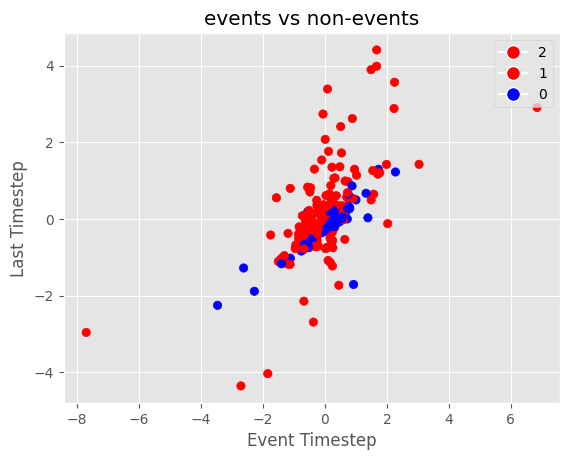

In [15]:
plt.scatter(feats_df['timestep_event'], feats_df['timestep_last'], c=feats_df['label'].map({2: 'red', 1: 'red', 0: 'blue'}))

plt.xlabel('Event Timestep')
plt.ylabel('Last Timestep')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='2', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='blue', markersize=10)])

plt.title('events vs non-events')
plt.show()

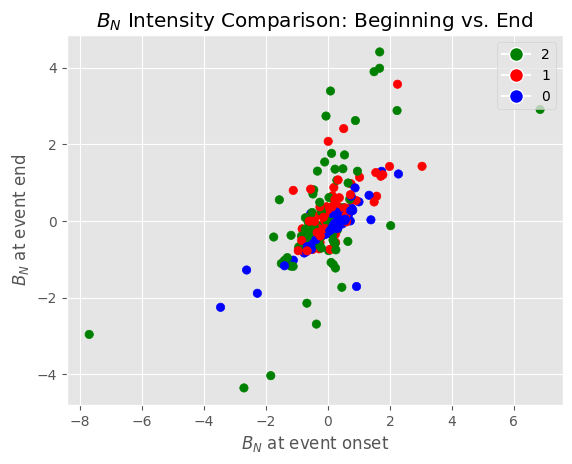

In [16]:
plt.scatter(feats_df['timestep_event'], feats_df['timestep_last'], c=feats_df['label'].map({2: 'green', 1: 'red', 0: 'blue'}))

plt.xlabel(r'$B_N$ at event onset')
plt.ylabel(r'$B_N$ at event end')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label='2', markerfacecolor='green', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='1', markerfacecolor='red', markersize=10),
                    plt.Line2D([0], [0], marker='o', color='w', label='0', markerfacecolor='blue', markersize=10)])

plt.title(r'$B_N$ Intensity Comparison: Beginning vs. End') # SSC (2) va SI (1) vs non-event (0)
plt.show()

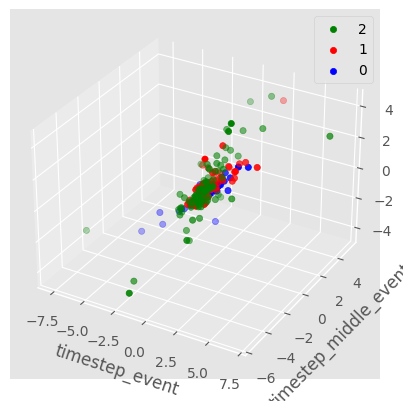

In [17]:
# columns
feat_discriminante = 'timestep_event'
feat_y = 'timestep_middle_event' 
feat_z = 'timestep_last' 
label = 'label'


# 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

colors = {2: 'green', 1: 'red', 0: 'blue'}

for label_name, label_color in colors.items():
    subset = feats_df[feats_df[label] == label_name]
    ax.scatter(subset[feat_discriminante], subset[feat_y], subset[feat_z], c=label_color, label=label_name)

ax.set_xlabel(feat_discriminante)
ax.set_ylabel(feat_y)
ax.set_zlabel(feat_z)

ax.legend()

plt.show()


#### PCA

Explained variation per principal component: [0.70778733 0.15886378 0.05939176 0.03066458 0.01328978 0.01060366
 0.00531437 0.00457897 0.00214467 0.001751  ]


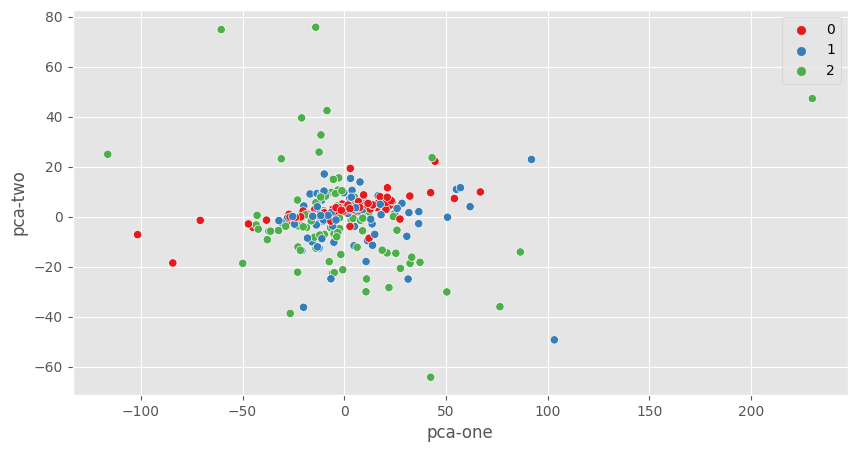

In [18]:
Sc_all_df = pd.DataFrame(Sx_train)

# PCA 
num_pc = 10
pca = PCA(n_components=num_pc) 
pca_result = pca.fit_transform(Sc_all_df) 

# put PC in feats_df 
feats = pd.DataFrame({})
feats['pca-one'] = pca_result[:,0]
feats['pca-two'] = pca_result[:,1] 
feats['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

# plot scatterplot of first PC on x axis and second PC on y axis
plt.figure(figsize=(10,5))
sns.scatterplot( 
    x='pca-one', 
    y='pca-two',
    hue=y_train_resampled, 
    palette=sns.color_palette('Set1', 3),
    data=feats,
    legend='full')
plt.show()

______

### Classification

#### Logistic Regression with 10-folds cross validation

In [19]:
def k_fold_cross_validation(X, y, num_folds, num_epochs, batch_size, random_seed=2):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_seed)
    fold = 0
    results = {}

    for train_index, val_index in kf.split(X):
        # get fold
        fold += 1
        print(f'\nFold {fold}/{num_folds}:')

        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]


        # define logistic regression model
        num_input = X_train.shape[-1]
        num_classes = y_train.unique().numel()
        model, optimizer, criterion = get_logistic_model(num_input, num_classes)

        # train model
        print('Training:')
        n_samples_train = X_train.shape[0]
        train_logistic_model(X_train, y_train, model, optimizer, criterion, num_epochs, n_samples_train, batch_size, verbose=True)


        # compute accuracy on validation set
        print('\nValidation:')
        resp_val = model.forward(X_val)
        avg_loss_val = criterion(resp_val, y_val)

        y_hat_val = resp_val.argmax(dim=1)
        accuracy_val = (y_val == y_hat_val).float().mean()

        print('Validation, average loss = {:1.3f}, accuracy = {:1.3f}'.format(avg_loss_val, accuracy_val))

        # other metrics
        precision = precision_score(y_val, y_hat_val, average='weighted')
        recall = recall_score(y_val, y_hat_val, average='weighted')
        f1 = f1_score(y_val, y_hat_val, average='weighted')

        results[fold] = {'model':model, 'validation_accuracy':accuracy_val.item(),
                         'precision':precision, 'recall':recall, 'F1':f1}

    return results


# 10-folds CV
num_folds = 10
num_epochs = 10
batch_size = 32
results = k_fold_cross_validation(Sx_train, y_train_resampled, num_folds, num_epochs, batch_size)


Fold 1/10:
Training:
Epoch 0, average loss = 1.330, accuracy = 0.374
Epoch 1, average loss = 1.260, accuracy = 0.416
Epoch 2, average loss = 1.171, accuracy = 0.300
Epoch 3, average loss = 1.082, accuracy = 0.473
Epoch 4, average loss = 1.057, accuracy = 0.580
Epoch 5, average loss = 1.051, accuracy = 0.477
Epoch 6, average loss = 1.031, accuracy = 0.584
Epoch 7, average loss = 1.038, accuracy = 0.494
Epoch 8, average loss = 1.020, accuracy = 0.605
Epoch 9, average loss = 1.029, accuracy = 0.506

Validation:
Validation, average loss = 1.029, accuracy = 0.481

Fold 2/10:
Training:
Epoch 0, average loss = 1.187, accuracy = 0.469
Epoch 1, average loss = 1.201, accuracy = 0.379
Epoch 2, average loss = 1.153, accuracy = 0.519
Epoch 3, average loss = 1.068, accuracy = 0.457
Epoch 4, average loss = 1.030, accuracy = 0.568
Epoch 5, average loss = 1.010, accuracy = 0.556
Epoch 6, average loss = 0.997, accuracy = 0.547
Epoch 7, average loss = 0.983, accuracy = 0.560
Epoch 8, average loss = 0.98

In [20]:
results

{1: {'model': Sequential(
    (0): Linear(in_features=1201, out_features=3, bias=True)
    (1): LogSoftmax(dim=1)
  ),
  'validation_accuracy': 0.48148149251937866,
  'precision': 0.6351410934744267,
  'recall': 0.48148148148148145,
  'F1': 0.4938799762329175},
 2: {'model': Sequential(
    (0): Linear(in_features=1201, out_features=3, bias=True)
    (1): LogSoftmax(dim=1)
  ),
  'validation_accuracy': 0.48148149251937866,
  'precision': 0.4939393939393939,
  'recall': 0.48148148148148145,
  'F1': 0.48677248677248675},
 3: {'model': Sequential(
    (0): Linear(in_features=1201, out_features=3, bias=True)
    (1): LogSoftmax(dim=1)
  ),
  'validation_accuracy': 0.5925925970077515,
  'precision': 0.5894179894179894,
  'recall': 0.5925925925925926,
  'F1': 0.5737628384687207},
 4: {'model': Sequential(
    (0): Linear(in_features=1201, out_features=3, bias=True)
    (1): LogSoftmax(dim=1)
  ),
  'validation_accuracy': 0.5185185074806213,
  'precision': 0.5712962962962963,
  'recall': 0.51

In [21]:
acc, precision, recall, f1 = 0, 0, 0, 0

for k in results.keys():
    acc += results[k]['validation_accuracy']
    precision += results[k]['precision']
    recall += results[k]['recall']
    f1 += results[k]['F1']

print('Average accuracy (10-folds Cross-Validation): {}'.format(acc/num_folds))
print('Average precision (10-folds Cross-Validation): {}'.format(precision/num_folds))
print('Average recall (10-folds Cross-Validation): {}'.format(recall/num_folds))
print('Average F1 (10-folds Cross-Validation): {}'.format(f1/num_folds))

Average accuracy (10-folds Cross-Validation): 0.5111111134290696
Average precision (10-folds Cross-Validation): 0.5342551173106729
Average recall (10-folds Cross-Validation): 0.5111111111111112
Average F1 (10-folds Cross-Validation): 0.5068153788126193


In [22]:
max_recall = 0
for k in results.keys():
    if results[k]['recall'] > max_recall:
        max_recall = results[k]['recall']
        new_best_model = k

# model with highest recall
print('model with highest recall: fold {}, recall {}'.format(new_best_model, 
                                                             results[new_best_model]['recall'] ))

model with highest recall: fold 7, recall 0.6296296296296297


In [23]:
best_model = results[new_best_model]['model']
criterion = torch.nn.NLLLoss() # negative log likelihood loss

# TEST SET
# accuracy
resp = best_model.forward(Sx_test)
avg_loss = criterion(resp, y_test)

y_hat = resp.argmax(dim=1)
acc = (y_test == y_hat).float().mean()

print('Model accuracy: ', acc.item())

# confusion matrix
preds_test = y_hat.numpy()
true_test = y_test.numpy()
confusion = confusion_matrix(true_test, preds_test)

# probabilities of class assignment
best_model.eval() 
with torch.no_grad():
    logits = best_model(Sx_test)
    probs = torch.softmax(logits, dim=1)

Model accuracy:  0.457446813583374


In [24]:
probs

tensor([[4.6672e-01, 1.4370e-01, 3.8958e-01],
        [6.9710e-01, 6.7016e-02, 2.3589e-01],
        [1.3066e-01, 2.4634e-01, 6.2300e-01],
        [1.2555e-01, 4.1383e-01, 4.6062e-01],
        [2.0065e-01, 6.1790e-01, 1.8145e-01],
        [4.1480e-01, 3.6213e-01, 2.2307e-01],
        [5.5296e-01, 1.8030e-01, 2.6674e-01],
        [5.3332e-01, 1.5533e-01, 3.1136e-01],
        [3.9415e-01, 2.7770e-01, 3.2814e-01],
        [2.3495e-01, 2.2232e-01, 5.4273e-01],
        [4.1799e-01, 2.6936e-01, 3.1265e-01],
        [5.2330e-01, 6.5335e-02, 4.1136e-01],
        [5.1081e-01, 5.3659e-02, 4.3553e-01],
        [3.0653e-01, 3.1113e-01, 3.8234e-01],
        [4.1469e-01, 3.2853e-01, 2.5678e-01],
        [2.5518e-01, 4.5626e-01, 2.8856e-01],
        [3.4811e-01, 3.1407e-01, 3.3782e-01],
        [3.8823e-01, 3.3811e-01, 2.7366e-01],
        [3.7390e-01, 2.5604e-01, 3.7006e-01],
        [1.0041e-01, 4.1267e-01, 4.8692e-01],
        [1.6053e-01, 5.9816e-01, 2.4131e-01],
        [3.7721e-01, 3.0306e-01, 3

In [25]:
confusion

array([[27,  2,  1],
       [ 5,  5, 11],
       [21, 11, 11]])

In [26]:
Counter(y_test.numpy())

Counter({2: 43, 0: 30, 1: 21})

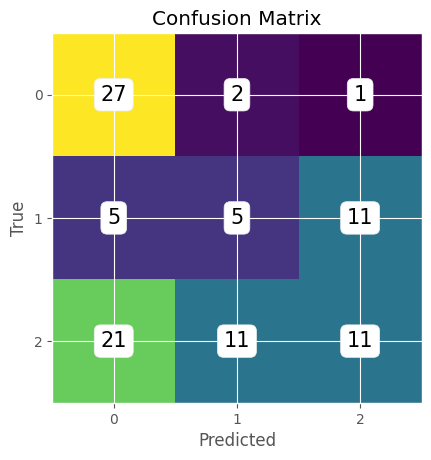

In [27]:
def plot_confusion_matrix(confusion):
    plt.figure()
    plt.imshow(confusion, cmap='viridis') 

    num_classes = confusion.shape[0]
    tick_locs = np.arange(num_classes)
    ticks = ['{}'.format(i) for i in range(num_classes)]

    plt.xticks(tick_locs, ticks)
    plt.yticks(tick_locs, ticks)

    plt.ylabel('True')
    plt.xlabel('Predicted')

    for i in range(num_classes):
        for j in range(num_classes):
            lab = f'{confusion[i, j]}'

            plt.text(j, i, lab, ha='center', va='center', color='black', fontsize=15, bbox=dict(boxstyle='round', fc='w'))

    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(confusion)


In [28]:
lab_to_int # SI have the most problematic prediction

{'non-event': 0, 'SI': 1, 'SSC': 2}

In [29]:
precision = precision_score(true_test, preds_test, average='weighted')
recall = recall_score(true_test, preds_test, average='weighted')
f1 = f1_score(true_test, preds_test, average='weighted')

print('Precision: {}\nRecall: {}\nF1: {}'.format(precision,recall,f1))

Precision: 0.44342095311236396
Recall: 0.4574468085106383
F1: 0.41740447879899306


In [30]:
print('\t\tNon-Event (0)  SI (1)  SSC (2)\nPrecision:\t{}\nRecall:\t\t{}\nF1:\t\t{}'.format(
                                                                                    precision_score(true_test, preds_test, average=None),
                                                                                    recall_score(true_test, preds_test, average=None),
                                                                                    f1_score(true_test, preds_test, average=None)))

		Non-Event (0)  SI (1)  SSC (2)
Precision:	[0.50943396 0.27777778 0.47826087]
Recall:		[0.9        0.23809524 0.25581395]
F1:		[0.65060241 0.25641026 0.33333333]


In [31]:
acc_log_reg_full = accuracy_score(true_test, preds_test)

In [32]:
precision_log_reg_full, recall_log_reg_full, f1_score_log_reg_full, support_log_reg_full = precision_recall_fscore_support(true_test, preds_test)
precision_log_reg_full, recall_log_reg_full, f1_score_log_reg_full, support_log_reg_full 

(array([0.50943396, 0.27777778, 0.47826087]),
 array([0.9       , 0.23809524, 0.25581395]),
 array([0.65060241, 0.25641026, 0.33333333]),
 array([30, 21, 43]))

___________

#### Support Vector Classifier with Grid Search and 10-folds cross validation

In [33]:
# SVC parameters
param_grid = { 
        'C': [ 0.1,  1. , 2., 10. ], # regularization
        'class_weight':[{0:1, 1:2.2, 2:1},
                        {0:1, # class : weight
                         1:2, # give weight 2 to class 1 (SI event), and weight 1 to the other two, since SI are the most misclassified
                         2:1},  
                        {0:1, 1:1.5, 2:1.2},
                        {0:1, 1:2, 2:1.5}
                        ],
        'kernel': ['poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto'] # kernel coefficent for poly, rbf, sigmoid
        }


# 10 folds CV
n_splits, n_repeats = 10, 5
cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=2)
grid_search = GridSearchCV(estimator=SVC(), 
                            param_grid=param_grid, 
                            scoring='accuracy', 
                            refit='accuracy', 
                            n_jobs=-1, 
                            cv=cv)
gridCV = grid_search.fit(Sx_train, y_train_resampled)
gridCV.best_params_

{'C': 10.0,
 'class_weight': {0: 1, 1: 1.5, 2: 1.2},
 'gamma': 'scale',
 'kernel': 'rbf'}

In [34]:
svc = SVC(**gridCV.best_params_, probability=True).fit(Sx_train, y_train_resampled)

In [35]:
svm_preds = svc.predict(Sx_test)
confusion = confusion_matrix(y_test, svm_preds)
confusion

array([[25,  4,  1],
       [ 8,  9,  4],
       [ 4, 14, 25]])

In [36]:
# probabilities class assignment
svc_probs = svc.predict_proba(Sx_test)
svc_probs

array([[2.65790627e-03, 7.36281192e-02, 9.23713975e-01],
       [2.06513057e-04, 1.79252508e-02, 9.81868236e-01],
       [2.19504902e-04, 6.49701186e-01, 3.50079309e-01],
       [1.59754116e-04, 8.71259098e-02, 9.12714336e-01],
       [2.25699896e-02, 2.18619070e-01, 7.58810940e-01],
       [7.29463049e-01, 1.91445807e-01, 7.90911434e-02],
       [5.95892861e-01, 2.58175505e-01, 1.45931634e-01],
       [4.31332493e-01, 1.21294998e-01, 4.47372509e-01],
       [4.52544609e-01, 3.73513068e-01, 1.73942324e-01],
       [1.09356708e-01, 1.97304839e-02, 8.70912808e-01],
       [2.76432685e-01, 3.00005489e-01, 4.23561826e-01],
       [1.54369625e-01, 1.99985617e-02, 8.25631813e-01],
       [4.95472183e-03, 1.24130632e-01, 8.70914647e-01],
       [5.72435742e-02, 5.97765424e-01, 3.44991001e-01],
       [7.77825495e-01, 1.04096718e-01, 1.18077786e-01],
       [4.78845182e-02, 5.04722602e-01, 4.47392880e-01],
       [4.16512422e-02, 4.35482603e-01, 5.22866155e-01],
       [7.05961997e-01, 1.70466

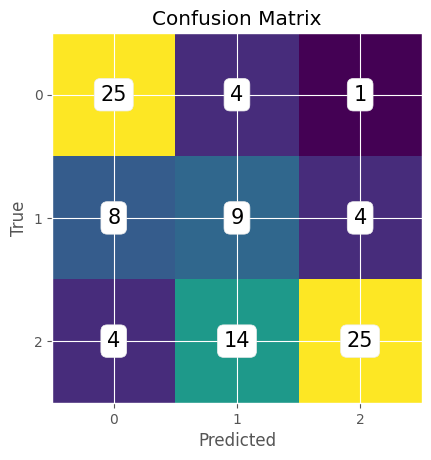

In [37]:
plot_confusion_matrix(confusion)

In [38]:
print('Accuracy on Test Set: {}'.format(accuracy_score(y_test, svm_preds)))

Accuracy on Test Set: 0.6276595744680851


In [39]:
precision = precision_score(y_test, svm_preds, average='weighted')
recall = recall_score(y_test, svm_preds, average='weighted')
f1 = f1_score(y_test, svm_preds, average='weighted')

print('Precision: {}\nRecall: {}\nF1: {}'.format(precision,recall,f1))

Precision: 0.6713149319532298
Recall: 0.6276595744680851
F1: 0.635267175489501


In [40]:
print('\t\tNon-Event (0)  SI (1)  SSC (2)\nPrecision:\t{}\nRecall:\t\t{}\nF1:\t\t{}'.format(
                                                                                    precision_score(y_test, svm_preds, average=None),
                                                                                    recall_score(y_test, svm_preds, average=None),
                                                                                    f1_score(y_test, svm_preds, average=None)))

		Non-Event (0)  SI (1)  SSC (2)
Precision:	[0.67567568 0.33333333 0.83333333]
Recall:		[0.83333333 0.42857143 0.58139535]
F1:		[0.74626866 0.375      0.68493151]


In [41]:
print(classification_report(y_test, svm_preds))

              precision    recall  f1-score   support

           0       0.68      0.83      0.75        30
           1       0.33      0.43      0.38        21
           2       0.83      0.58      0.68        43

    accuracy                           0.63        94
   macro avg       0.61      0.61      0.60        94
weighted avg       0.67      0.63      0.64        94



In [42]:
acc_svc_full = accuracy_score(y_test, svm_preds)
precision_svc_full, recall_svc_full, f1_score_svc_full, support_svc_full = precision_recall_fscore_support(y_test, svm_preds)
precision_svc_full, recall_svc_full, f1_score_svc_full, support_svc_full

(array([0.67567568, 0.33333333, 0.83333333]),
 array([0.83333333, 0.42857143, 0.58139535]),
 array([0.74626866, 0.375     , 0.68493151]),
 array([30, 21, 43]))

__________

#### Random Forest with Grid Search opt and 10 folds CV

In [43]:
rf_classifier = RandomForestClassifier(random_state=2)

param_grid = {
    'n_estimators': [50, 100, 150],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# 10 folds CV
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2)

# grid search with 10-fold cross-validation
grid_search_rf = GridSearchCV(estimator=rf_classifier, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           n_jobs=-1,
                           cv=cv)
grid_search_rf.fit(Sx_train.numpy(), y_train_resampled.numpy()) # must be numpy array

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=2, shuffle=True),
             estimator=RandomForestClassifier(random_state=2), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [44]:
grid_search_rf.best_params_

{'bootstrap': True,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

In [45]:
# best accuracy score
grid_search_rf.best_score_

0.7037037037037037

In [46]:
rf = RandomForestClassifier(**grid_search_rf.best_params_, random_state=2).fit(Sx_train.numpy(), y_train_resampled.numpy())

In [47]:
y_pred_rf = rf.predict(Sx_test.numpy())
acc_rf_full = accuracy_score(y_test.numpy(), y_pred_rf)
print('Test Accuracy: ', acc_rf_full)

Test Accuracy:  0.7553191489361702


In [48]:
# get probabilities
probs_rf_forest = rf.predict_proba(Sx_test.numpy())

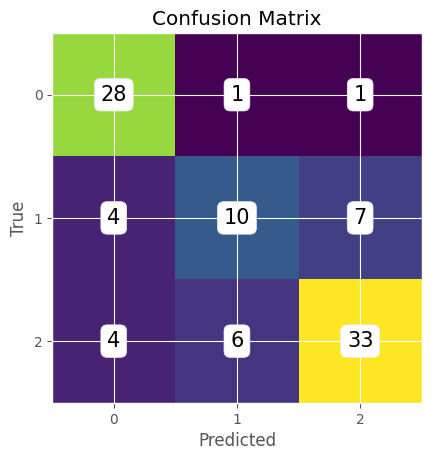

In [49]:
confusion_rf = confusion_matrix(y_test.numpy(), y_pred_rf)
plot_confusion_matrix(confusion_rf)

In [50]:
print(classification_report(y_test.numpy(), y_pred_rf))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85        30
           1       0.59      0.48      0.53        21
           2       0.80      0.77      0.79        43

    accuracy                           0.76        94
   macro avg       0.72      0.73      0.72        94
weighted avg       0.75      0.76      0.75        94



In [51]:
precision_rf_full, recall_rf_full, f1_score_rf_full, support_rf_full = precision_recall_fscore_support(y_test.numpy(), y_pred_rf)
precision_rf_full, recall_rf_full, f1_score_rf_full, support_rf_full 

(array([0.77777778, 0.58823529, 0.80487805]),
 array([0.93333333, 0.47619048, 0.76744186]),
 array([0.84848485, 0.52631579, 0.78571429]),
 array([30, 21, 43]))

In [52]:
precision_rf = precision_score(y_test.numpy(), y_pred_rf, average='weighted')
recall_rf = recall_score(y_test.numpy(), y_pred_rf, average='weighted')
f1_rf = f1_score(y_test.numpy(), y_pred_rf, average='weighted')

print('Precision: {}\nRecall: {}\nF1: {}'.format(precision_rf, recall_rf, f1_rf))

Precision: 0.7478301128443074
Recall: 0.7553191489361702
F1: 0.7477967161617778


_______

#### Summarize performances

In [53]:
result_report = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'Logistic Regression': [precision_log_reg_full.mean(), recall_log_reg_full.mean(), f1_score_log_reg_full.mean(), acc_log_reg_full],
    'SVC': [precision_svc_full.mean(), recall_svc_full.mean(), f1_score_svc_full.mean(), acc_svc_full],
    'Random Forest': [precision_rf_full.mean(), recall_rf_full.mean(), f1_score_rf_full.mean(), acc_rf_full]
}

result_report_df = pd.DataFrame(result_report)

result_report_df

,Metric,Logistic Regression,SVC,Random Forest
0,Precision,0.421824,0.614114,0.723630
1,Recall,0.464636,0.614433,0.725655
2,F1-Score,0.413449,0.602067,0.720172
3,Accuracy,0.457447,0.627660,0.755319


In [54]:
colmap = sns.light_palette("green", as_cmap=True)
result_report_df.style.background_gradient(cmap = colmap)

,Metric,Logistic Regression,SVC,Random Forest
0,Precision,0.421824,0.614114,0.723630
1,Recall,0.464636,0.614433,0.725655
2,F1-Score,0.413449,0.602067,0.720172
3,Accuracy,0.457447,0.627660,0.755319


In [55]:
result_report = {
    'Metric Type': ['', 'Precision', '', '', 'Recall', '', '', 'F1-Score', '' ],
    'Metric': ['Non-Event (0)', 'SI (1)', 'SSC (2)', 'Non-Event (0)', 'SI (1)', 'SSC (2)', 'Non-Event (0)', 'SI (1)', 'SSC (2)'],
    'Logistic Regression': np.concatenate((precision_log_reg_full, recall_log_reg_full, f1_score_log_reg_full)),
    'SVC': np.concatenate((precision_svc_full, recall_svc_full, f1_score_svc_full)),
    'Random Forest': np.concatenate((precision_rf_full, recall_rf_full, f1_score_rf_full))
}

result_report_df = pd.DataFrame(result_report)

result_report_df.set_index('Metric Type')

,Metric,Logistic Regression,SVC,Random Forest
Metric Type,,,,
,Non-Event (0),0.509434,0.675676,0.777778
Precision,SI (1),0.277778,0.333333,0.588235
,SSC (2),0.478261,0.833333,0.804878
,Non-Event (0),0.900000,0.833333,0.933333
Recall,SI (1),0.238095,0.428571,0.476190
,SSC (2),0.255814,0.581395,0.767442
,Non-Event (0),0.650602,0.746269,0.848485
F1-Score,SI (1),0.256410,0.375000,0.526316
,SSC (2),0.333333,0.684932,0.785714


In [56]:
result_report_df.style.background_gradient(cmap = colmap)

,Metric Type,Metric,Logistic Regression,SVC,Random Forest
0,,Non-Event (0),0.509434,0.675676,0.777778
1,Precision,SI (1),0.277778,0.333333,0.588235
2,,SSC (2),0.478261,0.833333,0.804878
3,,Non-Event (0),0.900000,0.833333,0.933333
4,Recall,SI (1),0.238095,0.428571,0.476190
5,,SSC (2),0.255814,0.581395,0.767442
6,,Non-Event (0),0.650602,0.746269,0.848485
7,F1-Score,SI (1),0.256410,0.375000,0.526316
8,,SSC (2),0.333333,0.684932,0.785714
